In [1]:
import numpy       as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
import RunHBV

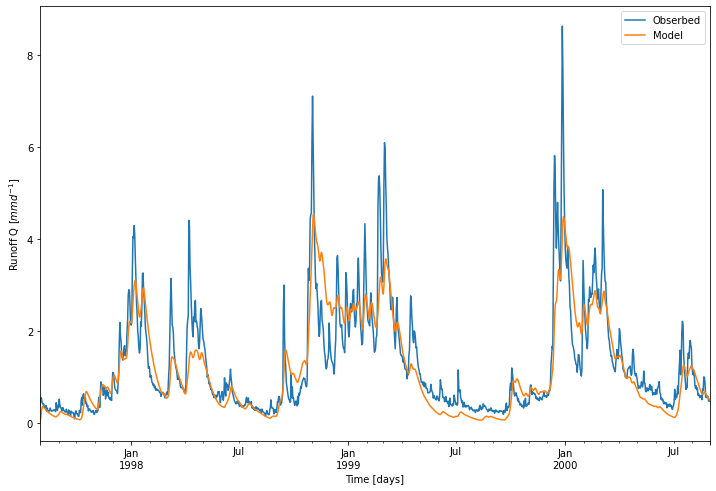

In [3]:
RunHBV.run()

In [4]:
def Weigfun(Tlag): 
    # WEIGFUN Summary of this function goes here
    #   Detailed explanation goes here
    nmax = int(np.ceil(Tlag))
    if nmax == 1: 
        Weigths = float(1)
    else:
        Weigths = np.zeros(nmax)

        th = Tlag / 2
        nh = int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i] = (float(i + 1) - 0.5) / th        
            i = nh
            Weigths[i] = (1 + (float(i+1) - 1) / th) * (th -int(np.floor(th))) / 2 + (1 + (Tlag - float(i+1)) / th) * (int(np.floor(th)) + 1 - th) / 2
            
        for i in range(nh+1, int(np.floor(Tlag))):
            Weigths[i] = (Tlag - float(i+1) + .5) / th

        if Tlag > int(np.floor(Tlag)):
            Weigths[int(np.floor(Tlag))] = (Tlag - int(np.floor(Tlag))) ** 2 / (2 * th)

        Weigths = Weigths / sum(Weigths)

    return(Weigths)
    # plot(Weigths) 
 

In [ ]:
def HBVMod(Par,forcing,Sin, hydrograph):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax = Par[0]
    Ce = Par[1]
    Sumax = Par[2]
    beta = Par[3]
    Pmax = Par[4]
    Tlag = Par[5]
    Kf = Par[6]
    Ks = Par[7]
    

    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['PE'].values


    tmax = len(Prec)
    
    # allocate Si, Su, Sf, Ss, Eidt, Eadt, Qtotdt
    
    Si = np.zeros(tmax)
    Su = np.zeros(tmax)
    Sf = np.zeros(tmax)
    Ss = np.zeros(tmax)
    Eidt = np.zeros(tmax)
    Eadt =  np.zeros(tmax)
    Qtotdt = np.zeros(tmax)
    Qs = np.zeros(tmax)
    Qf = np.zeros(tmax)
    
    # initialize Si, Su, Sf, Ss
    Si[0] = Sin[0]
    Su[0] = Sin[1]
    Sf[0] = Sin[2]
    Ss[0] = Sin[3]

    dt = 1

    #
    # Model 1 SOF1
    for i in range(0, tmax):
        Pdt = Prec[i] * dt
        Epdt = Etp[i] * dt
        
        # Interception Reservoir
        if Pdt > 0:
            Si[i] = Si[i] + Pdt
            Pedt = np.maximum(0, (Si[i] - Imax) / dt)
            Si[i] = Si[i] - Pedt
            Eidt[i] = 0
        else:
        # Evaporation only when there is no rainfall
            Pedt = np.maximum(0, (Si[i] - Imax) / dt) #is zero, because of no rainfall
            Eidt[i] = np.minimum(Epdt, Si[i] / dt)
            Si[i] = Si[i] - Pedt - Eidt[i]
        
        if i < tmax-1:
            Si[i+1] = Si[i]
        
        
        # Split Pe into Unsaturated Reservoir and Preferential reservoir
        if Pedt > 0:
            Cr = (Su[i] / Sumax) ** beta
            Qiudt = (1 - Cr) * Pedt # flux from Ir to Ur
            Su[i] = Su[i] + Qiudt
            Qufdt = Cr * Pedt #flux from Su to Sf
        else:
            Qufdt = 0
        
        # Transpiration
        Epdt = max(0, Epdt - Eidt[i])
        Eadt[i] = Epdt * (Su[i] / (Sumax * Ce))
        Eadt[i] = min(Su[i] / dt, Eadt[i])
        Su[i] = Su[i] - Eadt[i]
        
        # Percolation
        Qusdt = Pmax * (Su[i] / Sumax) * dt # Flux from Su to Ss
        Su[i] = Su[i] - Qusdt
        
        if i < tmax - 1:
            Su[i+1] = Su[i]
        
        # Fast Reservoir
        Sf[i] = Sf[i] + Qufdt
        Qfdt = dt * Kf * Sf[i]
        Sf[i] = Sf[i] - Qfdt
        if i < tmax-1:
            Sf[i+1] = Sf[i]
        
        # Slow Reservoir
        Ss[i] = Ss[i] + Qusdt
        Qsdt = dt * Ks * Ss[i]
        Ss[i] = Ss[i] - Qsdt
        if i < tmax-1:
            Ss[i+1] = Ss[i]
        
        Qtotdt[i] = Qsdt + Qfdt
        Qs[i] = Qsdt 
        Qf[i] = Qfdt 


    # Check Water Balance
    Sf = Si[-1] + Ss[-1] + Sf[-1] + Su[-1] #final storage
    Sin = sum(Sin) #initial storage
    WB = sum(Prec) - sum(Eidt) - sum(Eadt) - sum(Qtotdt) - Sf + Sin
    print(WB)
    # Offset Q

    Weigths = Weigfun(Tlag)
    
    Qm = np.convolve(Qtotdt, Weigths)
    Qm = Qm[0:tmax]
    forcing['Qm'] = Qm
    
    if hydrograph == 'TRUE':
    ## Plot
    # hour=1:tmax\
        fig, ax = plt.subplots(figsize=(12,8))
        forcing['Q'].plot(label='Obserbed', ax=ax)
        forcing['Qm'].plot(label='Model',  ax=ax)
        ax.legend()
        

    return(Qm)

    
    # leg['Qobs','Qmod']

In [ ]:
from datetime import date
data = pd.read_csv('Forcing.txt', skipinitialspace=True, delimiter='\t', names=['year', 'month', 'day', 'P', 'Q', 'PE'])
forcing = pd.DataFrame()
forcing['P'] = data['P']
forcing['PE'] = data['PE']
forcing['Q'] = data['Q']
forcing.index = data.apply(lambda x: date(int(x.year), int(x.month), int(x.day)), axis=1)
forcing.index = pd.to_datetime(forcing.index, format='%Y-%m-%d')


In [ ]:
          #      Imax Ce Sumax beta Pmax   Tlag   Kf  Ks
Par = np.array([2,   .5,  100,   2,  .01,    5,   .05,  .001])
Par = np.array([2,   .5,  100,   2,  .01,    5,   .05,  .001])

              #Si, Su,   Sf, Ss
Sin = np.array([0,  100,  0,  5  ])


Qm = HBVMod(Par, forcing , Sin, hydrograph='TRUE')